In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betaln, binom
from scipy.stats import beta as betadist
import seaborn as sns
import matplotlib.patches as patches

np.set_printoptions(suppress=True)
import matplotlib
matplotlib.rc('font', family='serif', serif='cm10')

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath\usepackage{amsfonts}'

np.random.seed(0)

arrow_kw = dict(arrowstyle="Simple, tail_width=0.5, head_width=10, head_length=10")

# Beta-Binomial (2 Models)

## Helpers

In [2]:
def beta_binom(prior, y):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    
    alpha, beta = prior
    h = np.sum(y)
    n = len(y)
    p_y = binom(n, h) * np.exp(betaln(alpha + h, beta + n - h) - betaln(alpha, beta))
    return p_y

def beta_binom_n(prior, h, n=50):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    """
    
    alpha, beta = prior
    p_y = binom(n, h) * np.exp(betaln(alpha + h, beta + n - h) - betaln(alpha, beta))
    return p_y

def prior(pars):
    """Generates a random draw from the beta prior."""
    return betadist(pars[0], pars[1]).rvs()

def model(theta, n=50):
    """Implements the binomial likelihood with a single parameter `theta`."""
    return np.random.binomial(n=1, p=theta, size=n)

def pmp(y, m_idx):
    """Computes PMPs for a given model index."""
    
    p = 0.5 * beta_binom(prior_pars[m_idx], y)
    p = p / (0.5 * beta_binom(prior_pars[0], y) + 0.5 * beta_binom(prior_pars[1], y))
    return (p, 1 - p)

def mom(d):
    """Method of moments estimator for alpha and beta given an array of data `d`."""
    s_mean = np.mean(d)
    s_var = np.var(d, ddof=1)
    alpha = s_mean * (s_mean*(1 - s_mean) / s_var - 1)
    beta = (1 - s_mean) * (s_mean*(1 - s_mean) / s_var - 1)
    return alpha, beta

# Setup

## Parameter Priors

In [3]:
colors = {
    'model_1': '#481F70',
    'model_2': '#27AD81',
    'typical_data': '#b73779',
    'atypical_data': '#eb5760'
}

In [4]:
# Represents alpha and beta params for the beta priors
prior_pars = ((1, 10), (1, 20))

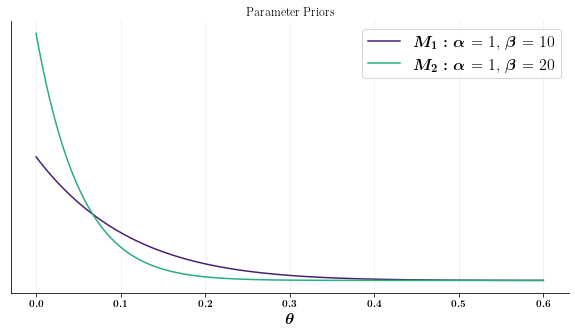

In [5]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
for i, (a, b) in enumerate(prior_pars, 1):
    distri = betadist(a, b)
    x = np.linspace(0, 0.6, 300)
    x_pdf = distri.pdf(x)
    ax.plot(x, x_pdf, label=fr"$M_{i}: \alpha$ = {a:d}, $\beta$ = {b:d}", color=colors[f'model_{i}'])
    ax.set_yticks([])
    ax.set_xlabel("$\\theta$", fontsize=16)
    ax.legend(fontsize=16)
ax.set_title('Parameter Priors')
ax.grid(alpha=0.2)
sns.despine()

## Model-Implied Data and PMPs

In [6]:
n_sim = 10000
n_obs = 50
pmps = {
    0: [],
    1: []
}
mls = {
    0: [],
    1: []
}
for n in range(n_sim):
    m = np.random.randint(0, 2)
    y = model(prior(prior_pars[m]), n=n_obs)
    post_probs = pmp(y, m)
    pmps[m].append(post_probs)
    mls[m].append((np.sum(y), beta_binom(prior_pars[m], y)))

# Convert to arrays
pmps[0] = np.array(pmps[0])
pmps[1] = np.array(pmps[1])

mls[0] = np.array(mls[0])
mls[1] = np.array(mls[1])

In [7]:
# f, axarr = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# cols = []
# for i in range(2):
#     sns.kdeplot(pmps[i][:, 0], ax=axarr[i], color='#5345ad', alpha=0.9, fill=True, label=r'$p(M_1\,|\,y)$')
#     sns.kdeplot(pmps[i][:, 1], ax=axarr[i], color='#ad4545', alpha=0.9, fill=True, label=r'$p(M_2\,|\,y)$')
#     axarr[i].set_title(r'PMP Distribution $M^* = {}$'.format(i+1), fontsize=18)
#     sns.despine(ax=axarr[i])
#     axarr[i].grid(alpha=0.1)
#     axarr[i].legend(fontsize=16)
# f.tight_layout()

## Marginal Likelihoods

In [8]:
# Atypical data
ya = np.repeat([0, 1], [15, 35])

# Typical data
yt = np.repeat([0, 1], [45, 5])

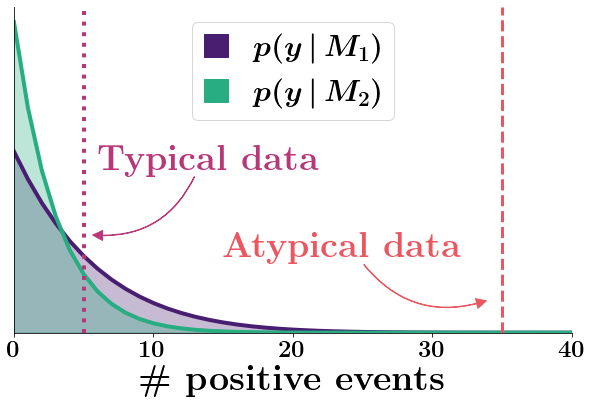

In [9]:
counts = np.arange(0, 51)
ml1 = np.array([beta_binom_n(prior_pars[0], h=c) for c in counts])
ml2 = np.array([beta_binom_n(prior_pars[1], h=c) for c in counts])

f, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

# M 1
idx = np.argsort(mls[0][:, 0])
ax.plot(counts, ml1, color=colors['model_1'], lw=4)
ax.fill_between(counts, ml1, color=colors['model_1'], alpha=0.3)

# M 2
ax.plot(counts, ml2, color=colors['model_2'], lw=4)
ax.fill_between(counts, ml2, color=colors['model_2'], alpha=0.3)

# Typical data
ax.axvline(np.sum(yt), color=colors['typical_data'], linestyle='dotted', lw=4)
ax.text(6, 0.15, r"\textbf{Typical data}", fontsize=36, color = colors['typical_data'], weight='bold') 
ax.add_patch(patches.FancyArrowPatch((13, 0.145), (5.5, 0.09), connectionstyle="arc3,rad=-.35", color=colors['typical_data'], **arrow_kw))

# Atypical data
ax.axvline(np.sum(ya), color=colors['atypical_data'], linestyle='dashed', lw=3)
ax.text(15, 0.07, r"\textbf{Atypical data}", fontsize=36, color = colors['atypical_data'], weight='bold') 
ax.add_patch(patches.FancyArrowPatch((25, 0.064), (34, 0.03), connectionstyle="arc3,rad=.35", color=colors['atypical_data'], **arrow_kw))


m1_legend_patch = patches.Patch(color=colors['model_1'], label=r'$p(y\,|\,M_1)$')
m2_legend_patch = patches.Patch(color=colors['model_2'], label=r'$p(y\,|\,M_2)$')
plt.legend(handles=[m1_legend_patch, m2_legend_patch], fontsize=30, loc = "upper center", handlelength=0.8, handleheight=0.8)

# Schmuck
sns.despine(ax=ax)
# ax.set_yticks([0, 0.04, 0.08, 0.12, 0.16])
# ax.set_yticklabels(['0', 0.04, 0.08, 0.12, 0.16])
# ax.set_ylabel('Density', fontsize=18)
ax.set_yticks([])
ax.set_xticks([0, 10, 20, 30, 40])
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_ylim([0, 0.3])
ax.set_xlim([0, 40])
#ax.legend(fontsize=24, loc="upper right")
ax.set_xlabel(r'\textbf{\# positive events}', fontsize=36)
# ax.set_title('Marginal Likelihoods', fontsize=20)
#ax.grid(alpha=0.2)
f.savefig('../output/plots/minimal-example-marginal-likelihood.pdf', dpi=300, bbox_inches='tight')

In [10]:
pmp_typical = pmp(yt, 0)
pmp_atypical = pmp(ya, 0)
print(pmp_typical)
print(pmp_atypical)

(0.5670034779973797, 0.4329965220026203)
(0.9993393495554659, 0.0006606504445341166)


## Model-Implied PMPs

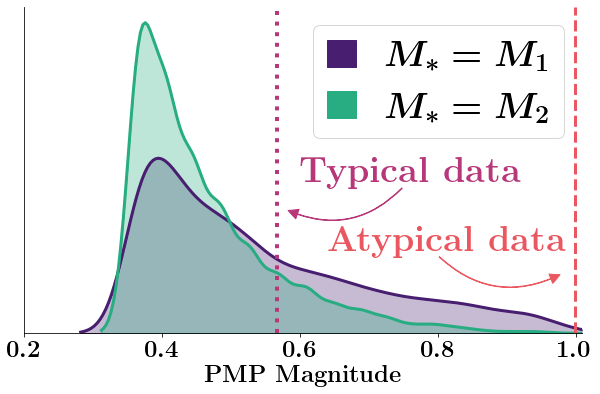

In [11]:
f, axarr = plt.subplots(1, 1, figsize=(10, 6))
sns.kdeplot(pmps[0][:, 0], ax=axarr, alpha=1, color=colors['model_1'], linewidth=3)
sns.kdeplot(pmps[0][:, 0], ax=axarr, alpha=0.3,
            color=colors['model_1'], fill=True)
sns.kdeplot(pmps[1][:, 1], ax=axarr, alpha=1, color=colors['model_2'], linewidth=3)
sns.kdeplot(pmps[1][:, 1], ax=axarr, alpha=0.3,
            color=colors['model_2'], fill=True)
# axarr.set_title(r'Model-Implied PMP Distributions'.format(i+1), fontsize=20)


# Typical data
axarr.axvline(pmp_typical[0], color=colors['typical_data'], linestyle='dotted', lw=4)
axarr.text(0.6, 3.3, r"\textbf{Typical data}", fontsize=36, color = colors['typical_data'], weight='bold') 
axarr.add_patch(patches.FancyArrowPatch((0.75, 3.2), (0.58, 2.7), connectionstyle="arc3,rad=-.35", color=colors['typical_data'], **arrow_kw))

# Atypical data
axarr.axvline(pmp_atypical[0], color=colors['atypical_data'], linestyle='dashed', lw=3)
axarr.text(0.64, 1.8, r"\textbf{Atypical data}", fontsize=36, color = colors['atypical_data'], weight='bold') 
axarr.add_patch(patches.FancyArrowPatch((0.8, 1.7), (0.98, 1.3), connectionstyle="arc3,rad=.35", color=colors['atypical_data'], **arrow_kw))

m1_legend_patch = patches.Patch(color=colors['model_1'], label=r'$M_*=M_1$')
m2_legend_patch = patches.Patch(color=colors['model_2'], label=r'$M_*=M_2$')
plt.legend(handles=[m1_legend_patch, m2_legend_patch], fontsize=36, loc = "best", handlelength=0.8, handleheight=0.8)
sns.despine(ax=axarr)

# axarr.grid(alpha=0.2)
axarr.set_yticks([])
axarr.tick_params(axis='both', which='major', labelsize=24)
axarr.set_xlabel(r'\textbf{PMP Magnitude}', fontsize=24)
axarr.set_ylabel('')
axarr.set_xlim([0.2, 1.01])
f.savefig('../output/plots/minimal-example-pmp.pdf', dpi=300, bbox_inches='tight')
# f.tight_layout()

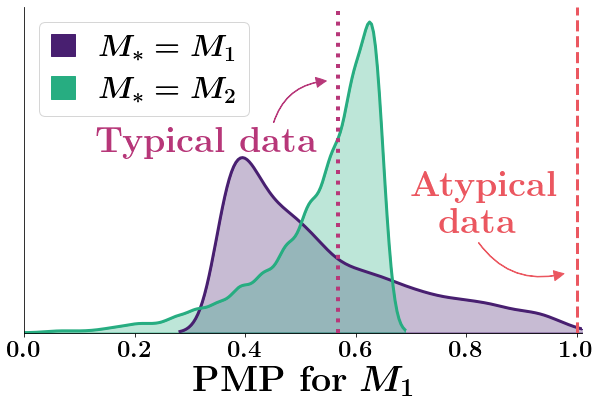

In [26]:
f, axarr = plt.subplots(1, 1, figsize=(10, 6))
sns.kdeplot(pmps[0][:, 0], ax=axarr, alpha=1, color=colors['model_1'], linewidth=3)
sns.kdeplot(pmps[0][:, 0], ax=axarr, alpha=0.3,
            color=colors['model_1'], fill=True)
sns.kdeplot(1-pmps[1][:, 1], ax=axarr, alpha=1, color=colors['model_2'], linewidth=3)
sns.kdeplot(1-pmps[1][:, 1], ax=axarr, alpha=0.3,
            color=colors['model_2'], fill=True)
# axarr.set_title(r'Model-Implied PMP Distributions'.format(i+1), fontsize=20)


# Typical data
axarr.axvline(pmp_typical[0], color=colors['typical_data'], linestyle='dotted', lw=4)
axarr.text(0.13, 3.95, r"\textbf{Typical data}", fontsize=36, color = colors['typical_data'], weight='bold') 
axarr.add_patch(patches.FancyArrowPatch((0.45, 4.55), (0.55, 5.5), connectionstyle="arc3,rad=-.35", color=colors['typical_data'], **arrow_kw))

# Atypical data
axarr.axvline(pmp_atypical[0], color=colors['atypical_data'], linestyle='dashed', lw=3)
axarr.text(0.7, 3, r"\textbf{Atypical}", fontsize=36, color = colors['atypical_data'], weight='bold') 
axarr.text(0.75, 2.2, r"\textbf{data}", fontsize=36, color = colors['atypical_data'], weight='bold') 
axarr.add_patch(patches.FancyArrowPatch((0.82, 2), (0.98, 1.3), connectionstyle="arc3,rad=.35", color=colors['atypical_data'], **arrow_kw))

m1_legend_patch = patches.Patch(color=colors['model_1'], label=r'$M_*=M_1$')
m2_legend_patch = patches.Patch(color=colors['model_2'], label=r'$M_*=M_2$')
plt.legend(handles=[m1_legend_patch, m2_legend_patch], fontsize=30, loc = "best", handlelength=0.8, handleheight=0.8)
sns.despine(ax=axarr)

# axarr.grid(alpha=0.2)
axarr.set_yticks([])
axarr.tick_params(axis='both', which='major', labelsize=24)
#axarr.set_xlabel(r'$p(M_1\,|\,y)$', fontsize=36)
axarr.set_xlabel(r'\textbf{PMP for} $M_1$', fontsize=36)
axarr.set_ylabel('')
axarr.set_xlim([0.0, 1.01])
f.savefig('../output/plots/minimal-example-pmp_version_2.pdf', dpi=300, bbox_inches='tight')
# f.tight_layout()

## Meta-Models
Using MLE, since predictive distribution $\approx$ likelihood with MLE estimates for K=5000 simulations.

In [13]:
# MLE of meta models
alpha1, beta1 = mom(pmps[0][:, 0])
alpha2, beta2 = mom(pmps[1][:, 0])
dist1 = betadist(alpha1, beta1)
dist2 = betadist(alpha2, beta2)
mean1 = dist1.mean()
mean2 = dist2.mean()
matrix_pmp = np.array([[mean1, 1 - mean2], [1 - mean1, mean2]])

## Predictive Distributions

In [14]:
p_range = np.linspace(0, 1, 1000)
mix_dens1 = pmp_typical[0] * dist1.pdf(p_range) + pmp_typical[1] * dist2.pdf(p_range)
mix_dens2 = pmp_atypical[0] * dist1.pdf(p_range) + pmp_atypical[1] * dist2.pdf(p_range)

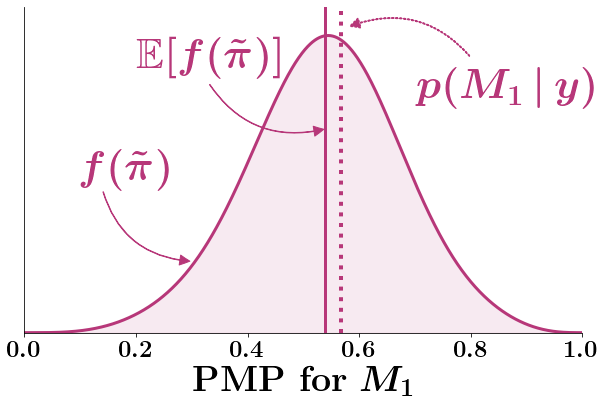

In [15]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Predictive Mixture
ax.text(0.1, 1.5, r'$f(\tilde{\pi})$', fontsize=42, color = colors['typical_data'], weight='bold') 
ax.add_patch(patches.FancyArrowPatch((0.14, 1.4), (0.3, 0.7), connectionstyle="arc3,rad=.35", color=colors['typical_data'], **arrow_kw))

ax.plot(p_range, mix_dens1, color=colors['typical_data'], linestyle='solid', lw=3)
ax.fill_between(p_range, mix_dens1, color=colors['typical_data'], alpha=0.1)
#ax.plot(p_range, mix_dens2, color=colors[0], label=r'$f(\tilde{\pi})$ atypical $y$', linestyle='dashed', lw=2)
#ax.fill_between(p_range, mix_dens2, color=colors[0], alpha=0.1)

# Observed PMP
ax.axvline(pmp_typical[0], color=colors['typical_data'], linestyle='dotted', lw=4)
ax.text(0.7, 2.3, r"$p(M_1\,|\,y)$", fontsize=42, color = colors['typical_data'], weight='bold') 
ax.add_patch(patches.FancyArrowPatch((0.8, 2.7), (0.58, 3), connectionstyle="arc3,rad=.35", color=colors['typical_data'], linestyle='dotted', lw=1.5, **arrow_kw))

# Expected Value of Predictive Mixture
ax.axvline(np.mean(mix_dens1 * p_range), color=colors['typical_data'], linestyle='solid', lw=3)
ax.text(0.2, 2.6, r'$\mathbb{E}[f(\tilde{\pi})]$', fontsize=42, color = colors['typical_data'], weight='bold') 
ax.add_patch(patches.FancyArrowPatch((0.33, 2.45), (0.54, 2), connectionstyle="arc3,rad=.35", color=colors['typical_data'], **arrow_kw))


ax.set_yticks([])
ax.set_xlim([0, 1])
ax.set_ylim([0, 3.2])
#ax.legend(fontsize=20)
ax.set_xlabel(r'\textbf{PMP for} $M_1$', fontsize=36)
ax.tick_params(axis='both', which='major', labelsize=24)
sns.despine(ax=ax)
f.savefig('../output/plots/minimal-example-typical-predictive-mixture.pdf', dpi=300, bbox_inches='tight')

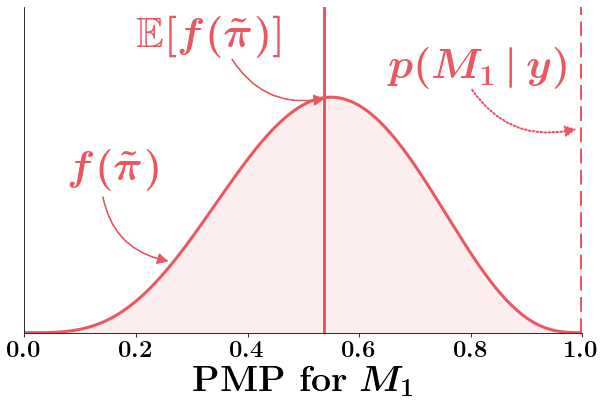

In [16]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Predictive Mixture
ax.text(0.08, 1.5, r'$f(\tilde{\pi})$', fontsize=42, color = colors['atypical_data'], weight='bold') 
ax.add_patch(patches.FancyArrowPatch((0.14, 1.35), (0.26, 0.7), connectionstyle="arc3,rad=.35", color=colors['atypical_data'], **arrow_kw))

ax.plot(p_range, mix_dens2, color=colors['atypical_data'], linestyle='solid', lw=3)
ax.fill_between(p_range, mix_dens2, color=colors['atypical_data'], alpha=0.1)


# Observed PMP
ax.axvline(pmp_atypical[0], color=colors['atypical_data'], linestyle='dashed', lw=4)
ax.text(0.65, 2.5, r"$p(M_1\,|\,y)$", fontsize=42, color = colors['atypical_data'], weight='bold') 
ax.add_patch(patches.FancyArrowPatch((0.8, 2.4), (0.99, 2), connectionstyle="arc3,rad=.35", color=colors['atypical_data'], linestyle='dotted', lw=1.5, **arrow_kw))

# Expected Value of Predictive Mixture
ax.axvline(np.mean(mix_dens2 * p_range), color=colors['atypical_data'], linestyle='solid', lw=3)
ax.text(0.2, 2.8, r'$\mathbb{E}[f(\tilde{\pi})]$', fontsize=42, color = colors['atypical_data'], weight='bold') 
ax.add_patch(patches.FancyArrowPatch((0.37, 2.7), (0.54, 2.3), connectionstyle="arc3,rad=.35", color=colors['atypical_data'], **arrow_kw))


ax.set_yticks([])
ax.set_xlim([0, 1])
ax.set_ylim([0, 3.2])
#ax.legend(fontsize=20)
ax.set_xlabel(r'\textbf{PMP for} $M_1$', fontsize=36)
ax.tick_params(axis='both', which='major', labelsize=24)
sns.despine(ax=ax)
f.savefig('../output/plots/minimal-example-atypical-predictive-mixture.pdf', dpi=300, bbox_inches='tight')

In [17]:
# Observed PMP, Lol
pmp_obs = pmp(y, 0)
print(pmp_obs)

(0.44439032310439985, 0.5556096768956001)


In [18]:
# Simulation-based Correction
matrix_pmp @ pmp_obs

array([0.49514431, 0.50485569])